## Test using fake data following HPDS format
- Age general distribution
- Age distribution by sex
- Comorbidities per day

Shiny App demo: https://avillachlab.shinyapps.io/demo/ 

In [1]:
#load the libraries
library( "ggplot2" )
library( "plyr" )
library( "plotly" )

NameError: name 'library' is not defined

In [43]:
##### file modified
inputPath <- "./"
inputFile <- "Zak_table_modified.txt"

# read the file and rename columns
dataInput <- read.delim( paste0( inputPath, inputFile ), header = FALSE, sep = "\t", colClasses = "character")
colnames(dataInput) <- c("PATIENT_NUM", "CONCEPT_PATH", "NVAL_NUM", "TVAL_CHAR", "START_DATE", "AGE", "SEX")

#for the diagnostic, we select the last item in the concept path
dataInput$DIAGNOSE <- sapply(strsplit( as.character(dataInput$CONCEPT_PATH), "[\\]"),function(x)x[length(x)])

#we create one subset of the data for the diagnosis analysis                             
dataSelection <- dataInput[, c("PATIENT_NUM", "DIAGNOSE", "START_DATE")]
dataSelection$START_DATE <- as.Date(dataSelection$START_DATE, format = "%d-%b-%y")
head( dataSelection )
                             
#we create one subset of the data for the general demographic analysis                             
demogData <- dataInput[ , c("PATIENT_NUM", "AGE", "SEX")]
demogData <- demogData[ ! duplicated( demogData ), ]
head(demogData)

demogData$AGE <- as.numeric( demogData$AGE )
demogData$SEX <- as.factor( demogData$SEX )

PATIENT_NUM,DIAGNOSE,START_DATE
1,Influenza with pneumonia,2020-01-01
1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-02
1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-03
2,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-04
2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-05
2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-06


,PATIENT_NUM,AGE,SEX
1,1,14,F
4,2,18,M
7,3,70,M
10,4,58,F
13,5,69,M
18,6,79,M


## Boxplot for the age distribution by sex

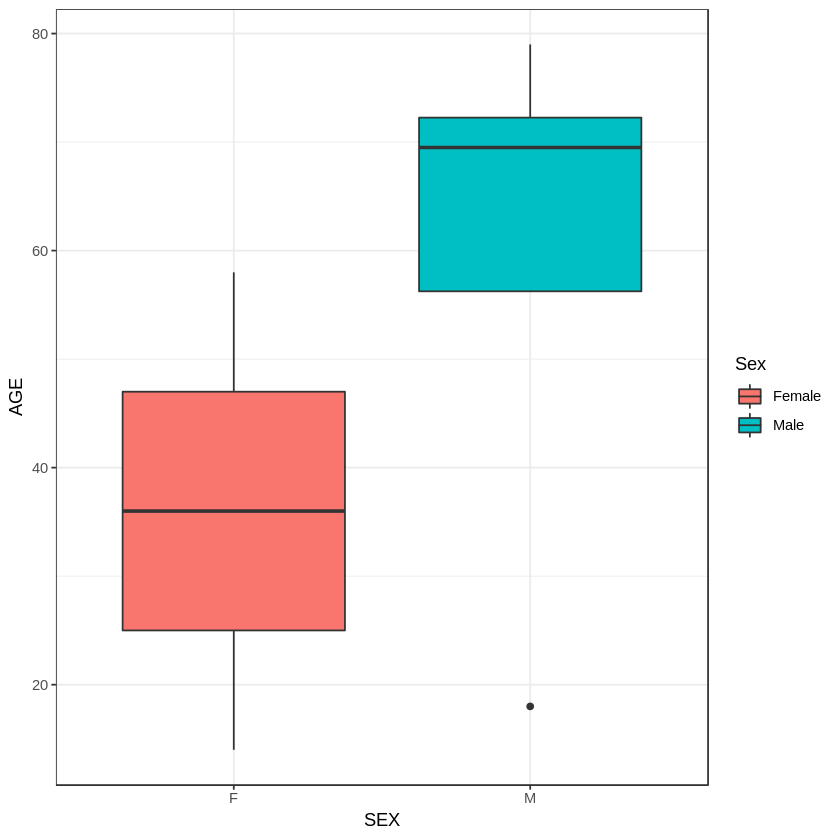

In [44]:
ageBP <- ggplot(demogData, aes(x=SEX, y=AGE, fill=SEX))+
  geom_boxplot()
ageBP + scale_fill_discrete(name="Sex",
                            breaks=c("F", "M"),
                            labels=c("Female", "Male"))

## Age distribution
- General age distribution
- Age distribution according to the sex of the patient

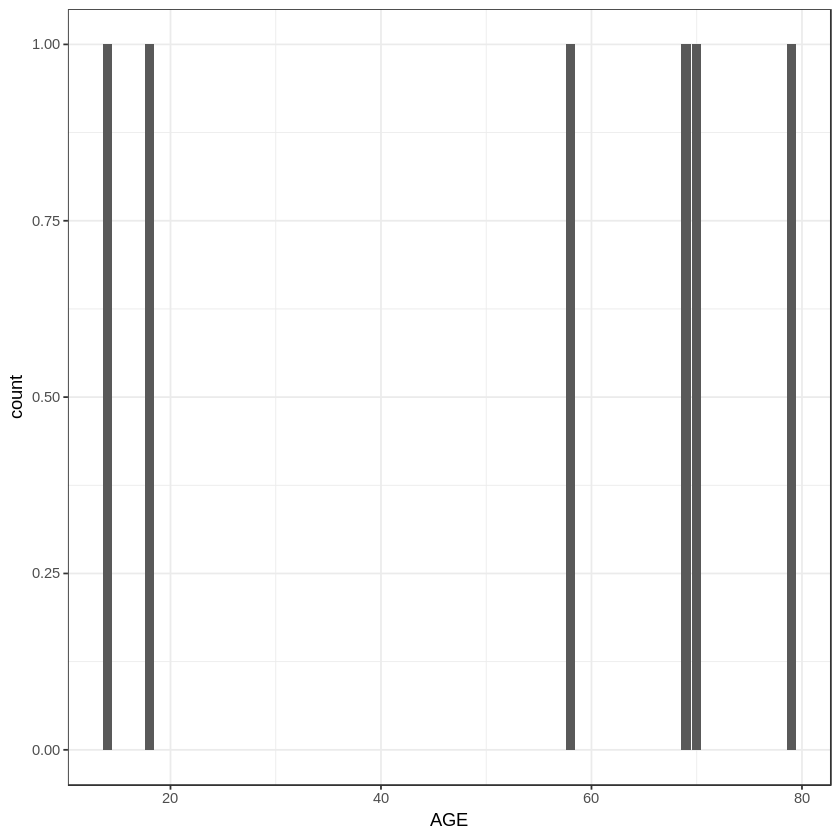

In [45]:
#general barplot
ggplot(demogData, aes(x=AGE)) + geom_bar()

In [49]:
min(demogData$AGE)
max(demogData$AGE)

[1] 14

[1] 79

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


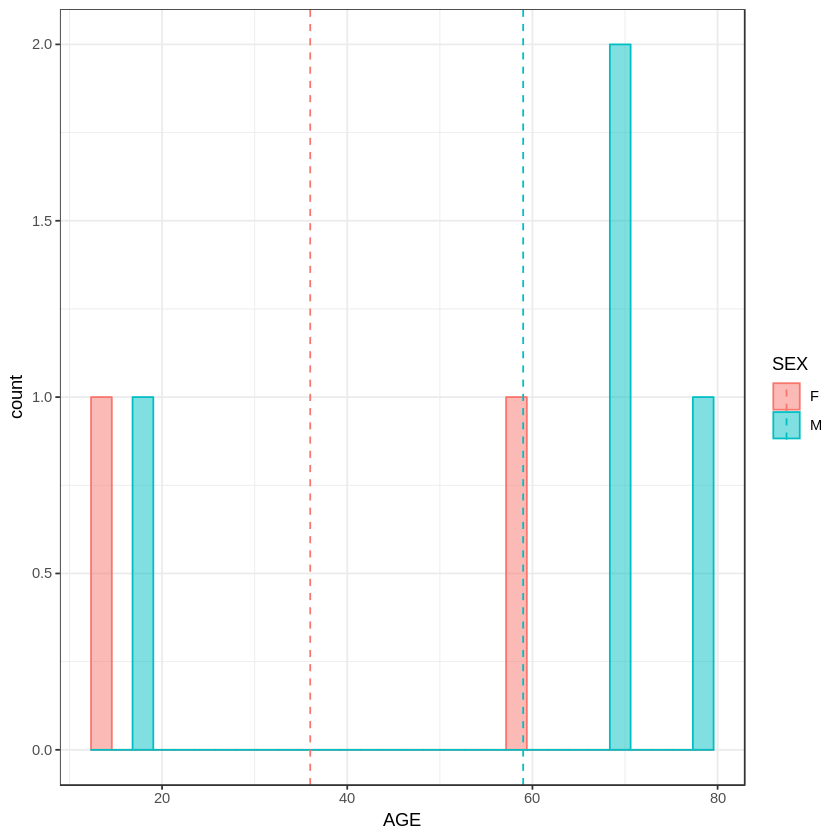

In [53]:
#estimate the mean age for males and females
mu <- ddply(demogData, "SEX", summarise, grp.mean=mean(AGE))

#histogram showing age according to sex
ggplot2::ggplot(demogData, aes(x=AGE, fill=SEX, color=SEX)) +
                geom_histogram(position="identity", alpha = 0.5) +
                geom_vline(data=mu, aes(xintercept=grp.mean, color=SEX),
                           linetype="dashed")

## Prepare the data to estimate the comorbidities per day

In [54]:
head(dataSelection)
output <- data.frame()

for( i in 1:length(unique( dataSelection$PATIENT_NUM))){

  selection <- dataSelection[ dataSelection$PATIENT_NUM == unique(dataSelection$PATIENT_NUM)[i], ]
  selection <- selection[ order( selection$START_DATE , decreasing = TRUE), ]

  for( j in 1:nrow(selection)){
    if( j == 1){
      selection$DAY[j] <- paste0("DAY ", j)
    }else{
      selection$DAY[j] <- paste0("DAY ", as.numeric(gsub("DAY ", "", selection$DAY[j-1])) + as.numeric(selection$START_DATE[j-1] - selection$START_DATE[j]) )

    }
  }
  output <- rbind(output, selection)
}

head(output)

PATIENT_NUM,DIAGNOSE,START_DATE
1,Influenza with pneumonia,2020-01-01
1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-02
1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-03
2,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-04
2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-05
2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-06


,PATIENT_NUM,DIAGNOSE,START_DATE,DAY
3,1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-03,DAY 1
2,1,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-02,DAY 2
1,1,Influenza with pneumonia,2020-01-01,DAY 3
6,2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-06,DAY 1
5,2,Influenza due to unidentified influenza virus with unspecified type of pneumonia,2020-01-05,DAY 2
4,2,Hemophilus influenzae (H. influenzae) infection in conditions classified elsewhere and of unspecified site,2020-01-04,DAY 3


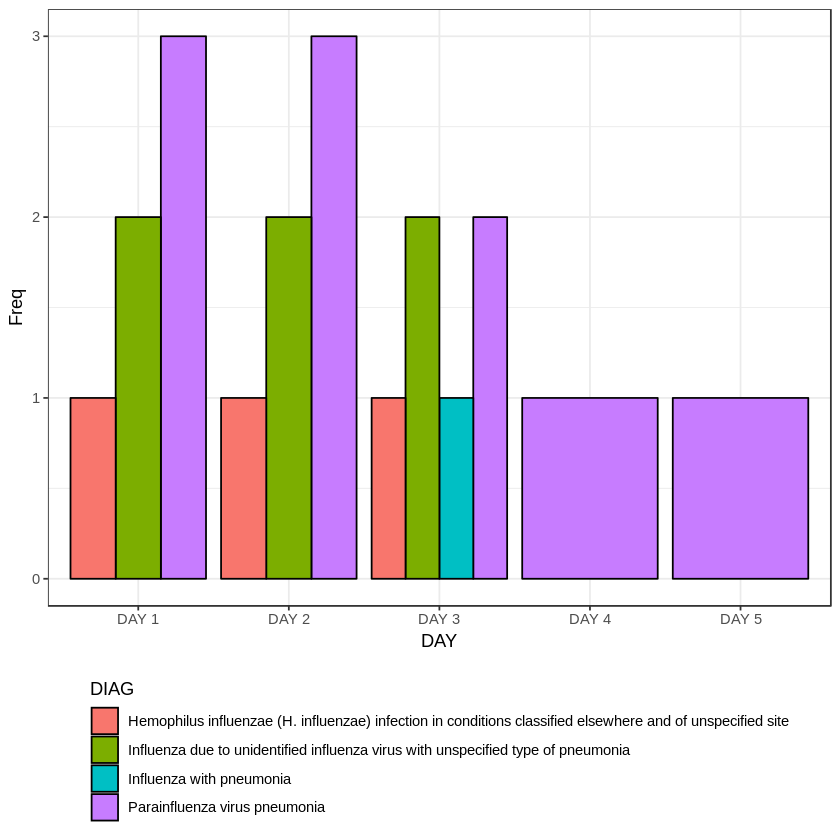

In [55]:
toplot <- as.data.frame( table( paste0( output$DIAGNOSE, "-", output$DAY)))
toplot$Prev <- (toplot$Freq/length(unique(output$PATIENT_NUM)))
toplot$DIAG <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 1)
toplot$DAY <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 2)

#barplot
p <- ggplot(data=toplot, aes(x=DAY, y=Freq, fill=DIAG)) +
  geom_bar(stat="identity", color="black", position=position_dodge())+
   theme(legend.position="bottom",
         legend.direction = "vertical")
p

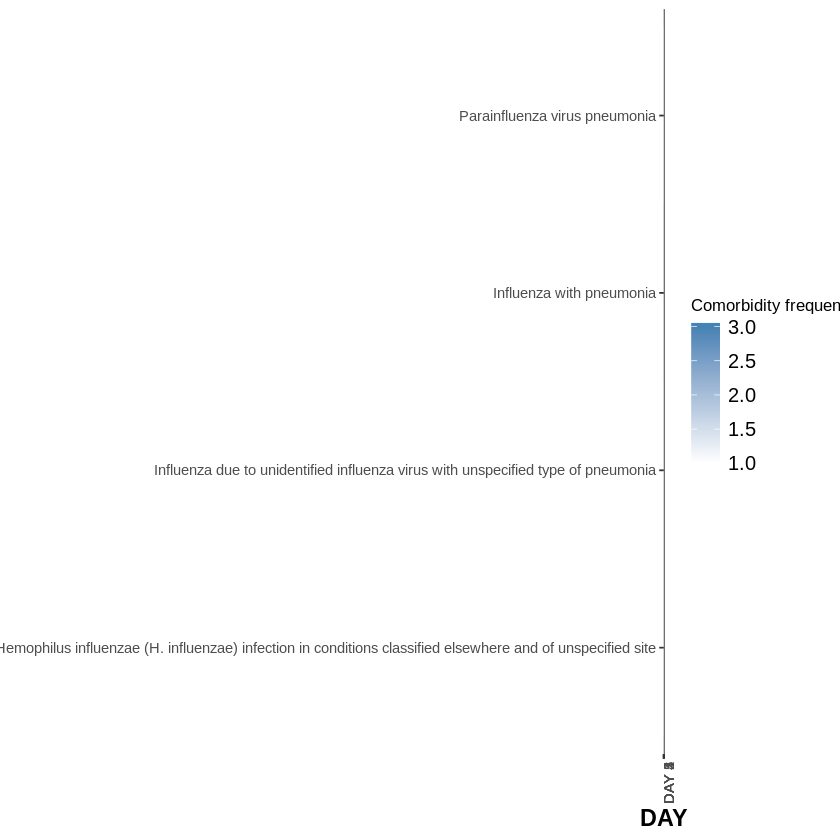

In [56]:
#htmp
htmp <- ggplot(toplot, aes(DAY, DIAG )) +
   geom_tile(aes(fill = Freq), color = "white") +
   scale_fill_gradient(low = "white", high = "steelblue") +
   theme(legend.title = element_text(size = 10),
         legend.text = element_text(size = 12),
         plot.title = element_text(size=16),
         axis.title=element_text(size=14,face="bold"),
         axis.text.x = element_text(angle = 90, hjust = 1)) +
   labs(fill = "Comorbidity frequency")

 htmp

In [36]:
#alternatives using plotly
# library(plotly)

# toplot <- as.data.frame( table( paste0( output$DIAGNOSE, "-", output$DAY)))
# toplot$Prev <- (toplot$Freq/length(unique(output$PATIENT_NUM)))
# toplot$DIAG <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 1)
# toplot$DAY <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 2)


# p <- ggplot(data=toplot, aes(x=DAY, y=Freq, fill=DIAG)) +
#   geom_bar(stat="identity", color="black", position=position_dodge())+
#   theme_minimal()+ theme(legend.position="bottom")
# p
#
# plotly( p )
#
#
# htmp <- ggplot(toplot, aes(DAY, DIAG )) +
#   geom_tile(aes(fill = Freq), color = "white") +
#   scale_fill_gradient(low = "white", high = "steelblue") +
#   theme(legend.title = element_text(size = 10),
#         legend.text = element_text(size = 12),
#         plot.title = element_text(size=16),
#         axis.title=element_text(size=14,face="bold"),
#         axis.text.x = element_text(angle = 90, hjust = 1)) +
#   labs(fill = "Comorbidity frequency")
#
# htmp
#
# fig <- plot_ly(
#   x = toplot$DAY, y = toplot$DIAG,
#   z = toplot$Freq, type = "heatmap"
# )

In [ ]:
#inputPath <- "./"
#inputFile <- "Zak_table.txt"

#library(plotly)

#theme_set(theme_bw())

#dataInput <- read.delim( paste0( inputPath, inputFile ), header = FALSE, sep = "\t", colClasses = "character")
#colnames(dataInput) <- c("PATIENT_NUM", "CONCEPT_PATH", "NVAL_NUM", "TVAL_CHAR", "START_DATE")
#dataInput$DIAGNOSE <- sapply(strsplit( as.character(dataInput$CONCEPT_PATH), "[\\]"),function(x)x[length(x)])
#dataSelection <- dataInput[, c("PATIENT_NUM", "DIAGNOSE", "START_DATE")]
#dataSelection$START_DATE <- as.Date(dataSelection$START_DATE, format = "%d-%b-%y")

#head(dataSelection)
#output <- data.frame()

#for( i in 1:length(unique( dataSelection$PATIENT_NUM))){

#  selection <- dataSelection[ dataSelection$PATIENT_NUM == unique(dataSelection$PATIENT_NUM)[i], ]
#  selection <- selection[ order( selection$START_DATE , decreasing = TRUE), ]

#  for( j in 1:nrow(selection)){
#    if( j == 1){
#      selection$DAY[j] <- paste0("DAY ", j)
#    }else{
#      selection$DAY[j] <- paste0("DAY ", as.numeric(gsub("DAY ", "", selection$DAY[j-1])) + as.numeric(selection$START_DATE[j-1] - selection$START_DATE[j]) )

#   }
# }
#  output <- rbind(output, selection)
#}

# Simulate COVID status
#covid_stat_df <- data.frame(PATIENT_NUM = unique(dataSelection$PATIENT_NUM),
#           covid_status = sample(c("Y", "N"),
#                                 size = length(unique(dataSelection$PATIENT_NUM)),
#                                 replace = T)
           )
#output <- merge(output, covid_stat_df)
#head(output)


# toplot <- as.data.frame( table( paste0( output$DIAGNOSE, "-", output$DAY)))
# toplot$Prev <- (toplot$Freq/length(unique(output$PATIENT_NUM)))
# toplot$DIAG <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 1)
# toplot$DAY <- sapply(strsplit( as.character(toplot$Var1), "-"), '[', 2)



#p <- ggplot(data=toplot, aes(x=DAY, y=Freq, fill=DIAG)) +
#  geom_bar(stat="identity", color="black", position=position_dodge())+
#   theme(legend.position="bottom",
#         legend.direction = "vertical")
#p

#plotly( p )


#htmp <- ggplot(toplot, aes(DAY, DIAG )) +
#  geom_tile(aes(fill = Freq), color = "white") +
#  scale_fill_gradient(low = "white", high = "steelblue") +
#  theme_bw() +
#  theme(legend.title = element_text(size = 10),
#        legend.text = element_text(size = 12),
#        plot.title = element_text(size=16),
#        axis.title=element_text(size=14,face="bold"),
#        axis.text.x = element_text(angle = 90, hjust = 1)) +
#  labs(fill = "Comorbidity frequency")

#htmp

#fig <- plot_ly(
#  x = toplot$DAY, y = toplot$DIAG,
#  z = toplot$Freq, type = "heatmap"
# )